![](https://live.staticflickr.com/5009/5277522498_7646c3b586_z.jpg)

# Energy Efficiency

This project aims to study the relationships between physical parameters of buildings and the power required to cool and heat them. The goal is to build machine learning models to predict these energy variables. This topic is important because it is directly related to energy efficiency, which is a critical issue in the current context of energy generation and consumption within a country. The dataset used in this study was constructed by the [Center of Machine Learning and Intelligent Systems](https://cml.ics.uci.edu/) in Irvine, California. It consists of 12 different building shapes simulated in Ecotect. A total of 768 building shapes were generated, each with its own dimensions and estimated heat and cooling load values.

# Dictionary (Columns)
- Heating Load (kW) 
- Cooling Load (kW)
- Relative Compactness
- Surface Area (m²)
- Wall Area (m²)
- Roof Area (m²)
- Overall Height (m)
- Orientation (2:North, 3:East, 4:South, 5:West)
- Glazing Area (% of floor area)
- Glazing Area Distribution ()

# References
- [Kaggle dataset](https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set?rvi=1)
- [Useful informations](https://pt.slideshare.net/NitinAgarwal53/exploratory-data-analysis-for-energy-efficiency)
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/242/energy+efficiency)
- [Introductory Paper](https://www.sciencedirect.com/science/article/abs/pii/S037877881200151X?via%3Dihub)

## 1) Importing Libraries and Loading Data

In [39]:
# Libraries:
import pandas as pd
import numpy as np
import warnings
from statsmodels.api import qqplot
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, f_regression, RFECV

import joblib
import os

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [2]:
# Reading dataset:
df = pd.read_csv("data\energy_efficiency_data.csv")

In [3]:
# Plotting some records:
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
# Informations about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


Let's change the data types to make the dataset smaller

In [5]:
# Numeric columns and Categorical columns:
num_cols = ["Relative_Compactness", "Surface_Area", 
            "Wall_Area", "Roof_Area", 
            "Overall_Height", "Glazing_Area", 
            "Heating_Load", "Cooling_Load"]

cat_cols = ["Orientation", "Glazing_Area_Distribution"]


# Changing data types:
df["Relative_Compactness"] = df["Relative_Compactness"].astype(np.float32)
df["Surface_Area"] = df["Surface_Area"].astype(np.float32)
df["Wall_Area"] = df["Wall_Area"].astype(np.float32)
df["Roof_Area"] = df["Roof_Area"].astype(np.float32)
df["Overall_Height"] = df["Overall_Height"].astype(np.float32)
df["Glazing_Area"] = df["Glazing_Area"].astype(np.float32)
df["Heating_Load"] = df["Heating_Load"].astype(np.float32)
df["Cooling_Load"] = df["Cooling_Load"].astype(np.float32)
df["Orientation"] = df["Orientation"].astype("category")
df["Glazing_Area_Distribution"] = df["Glazing_Area_Distribution"].astype("category")

In [6]:
# Information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Relative_Compactness       768 non-null    float32 
 1   Surface_Area               768 non-null    float32 
 2   Wall_Area                  768 non-null    float32 
 3   Roof_Area                  768 non-null    float32 
 4   Overall_Height             768 non-null    float32 
 5   Orientation                768 non-null    category
 6   Glazing_Area               768 non-null    float32 
 7   Glazing_Area_Distribution  768 non-null    category
 8   Heating_Load               768 non-null    float32 
 9   Cooling_Load               768 non-null    float32 
dtypes: category(2), float32(8)
memory usage: 26.0 KB


As we can see above, there are no null values. Since we do not have to clean up the data anymore, we can head to the Exploratory Data Analysis.

## 2) Exploratory Data Analysis

### 2.1) Descriptive Statistics and Distributions

Let's see some descriptive statistics:

In [7]:
# Plotting descriptive statistics of all variables:
df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Glazing_Area,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.00000,768.000000,768.00000,768.000000,768.000000,768.000000
mean,0.764167,671.708313,318.50000,176.604172,5.25000,0.234375,22.307199,24.587761
std,0.105777,88.086113,43.62648,45.165951,1.75114,0.133221,10.090196,9.513306
min,0.620000,514.500000,245.00000,110.250000,3.50000,0.000000,6.010000,10.900000
25%,0.682500,606.375000,294.00000,140.875000,3.50000,0.100000,12.992500,15.620000
50%,0.750000,673.750000,318.50000,183.750000,5.25000,0.250000,18.950000,22.080000
75%,0.830000,741.125000,343.00000,220.500000,7.00000,0.400000,31.667500,33.132501
max,0.980000,808.500000,416.50000,220.500000,7.00000,0.400000,43.099998,48.029999


Conclusions:

- Range of Relative Compactness is between 0 to 1, and represent the percentage of compactness of a building or closure. This means that more close to one more less will be the empty space inside the building.

- We have buildings with no Glazing Area.

In [8]:
# Class to plot statistical charts using subplots:
class Subplots:
    
    def __init__(self, dataframe, n_cols=4) -> None:
        self.dataframe = dataframe
        self.colunas_tamanho = len(dataframe.columns)
        self.n_cols = n_cols
        self.n_rows = (self.colunas_tamanho // 4) + 1
        
        
    def histogram(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.histplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], kde=True, color="b")    
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1

    
    def boxplot(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.boxplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], palette="pastel")    
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1
    
    def qq_plot(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    qqplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], line="s")  
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1

In [9]:
# Subplots instance:
subp = Subplots(df[num_cols])

#### 2.1.1) Histograms

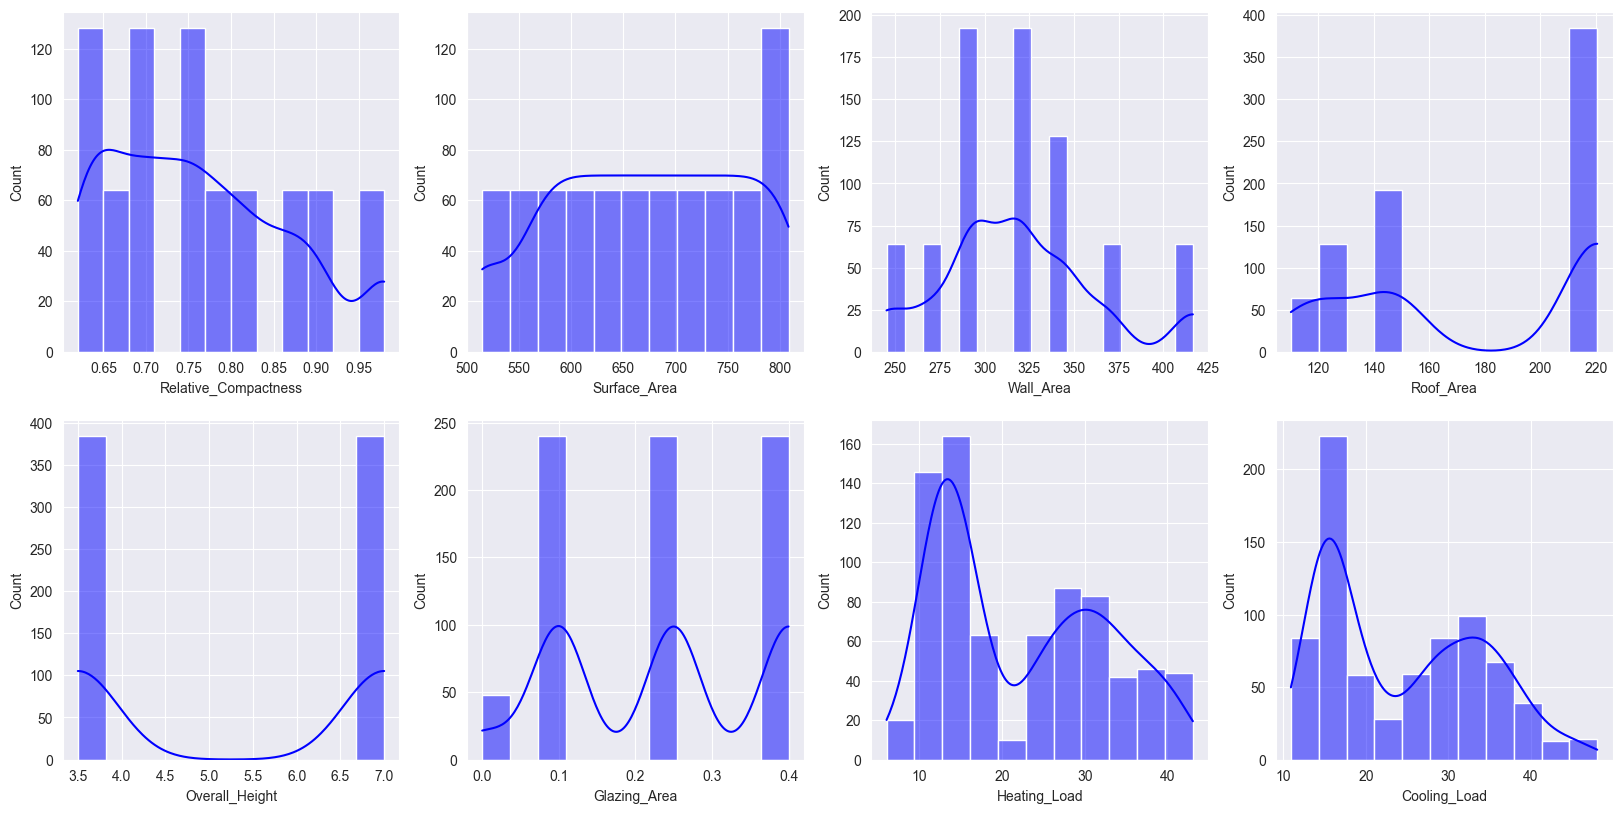

In [10]:
# Histogram plots
subp.histogram()

Conclusions:

- There is no normally distributed variable.

- Cooling Load and Heating Load have similiart distributions.

- There are just two values for Overall Height.

#### 2.1.2) Boxplots

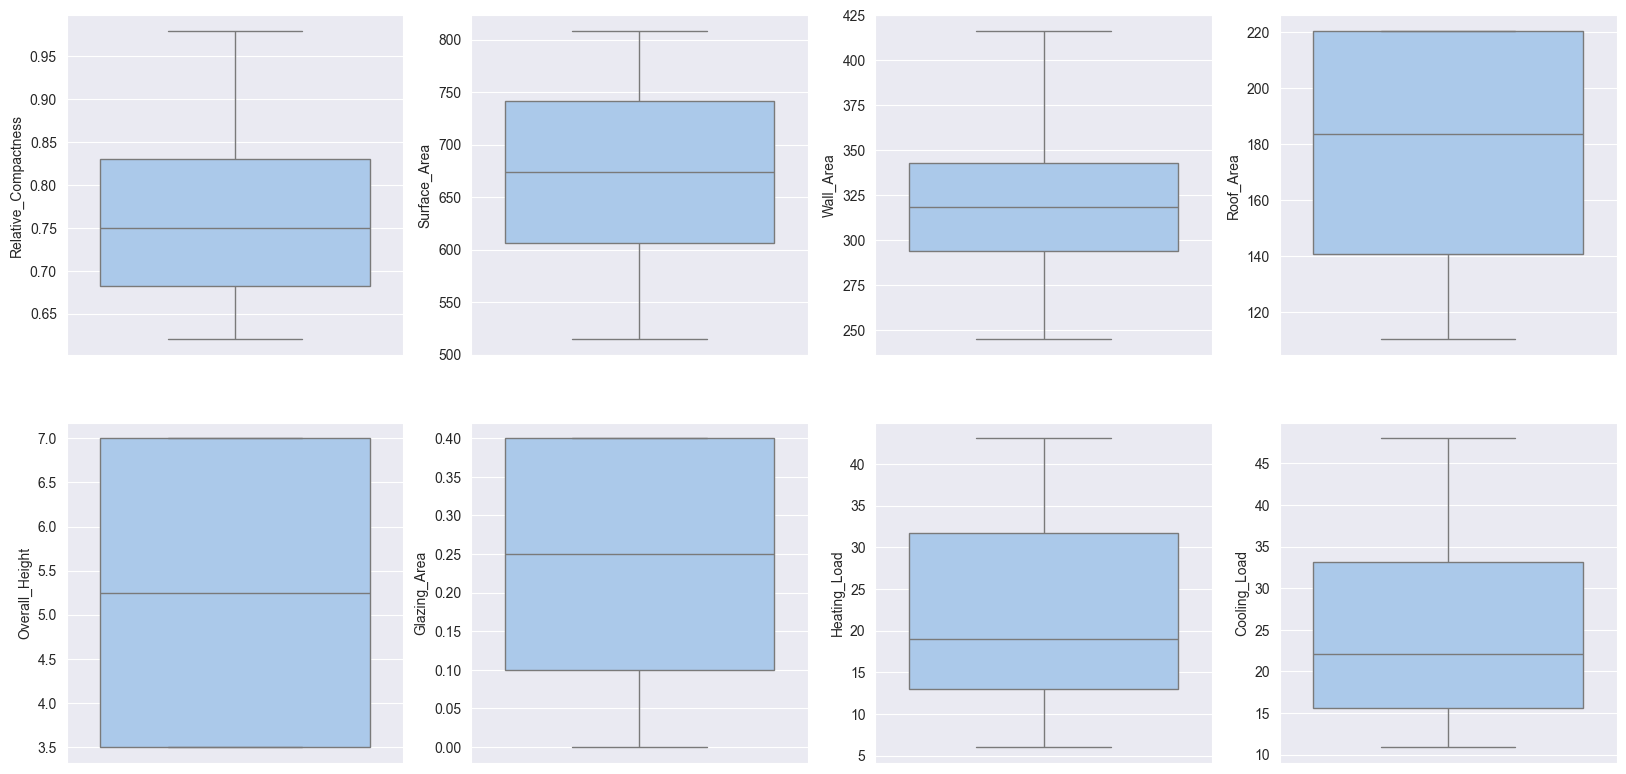

In [11]:
# Boxplots
subp.boxplot()

Conclusions:

- No outliers were detected using boxplot.

### 2.2) Correlations

In [12]:
# Function to plot heatmap of correlations:

def plot_correlation(dataframe):
    correlations=dataframe.corr()

    mask =  np.zeros_like(correlations)
    mask[np.triu_indices_from(mask)] = True


    plt.figure(figsize=(27, 10))
    sns.heatmap(correlations, annot=True, mask=mask, cmap="crest");

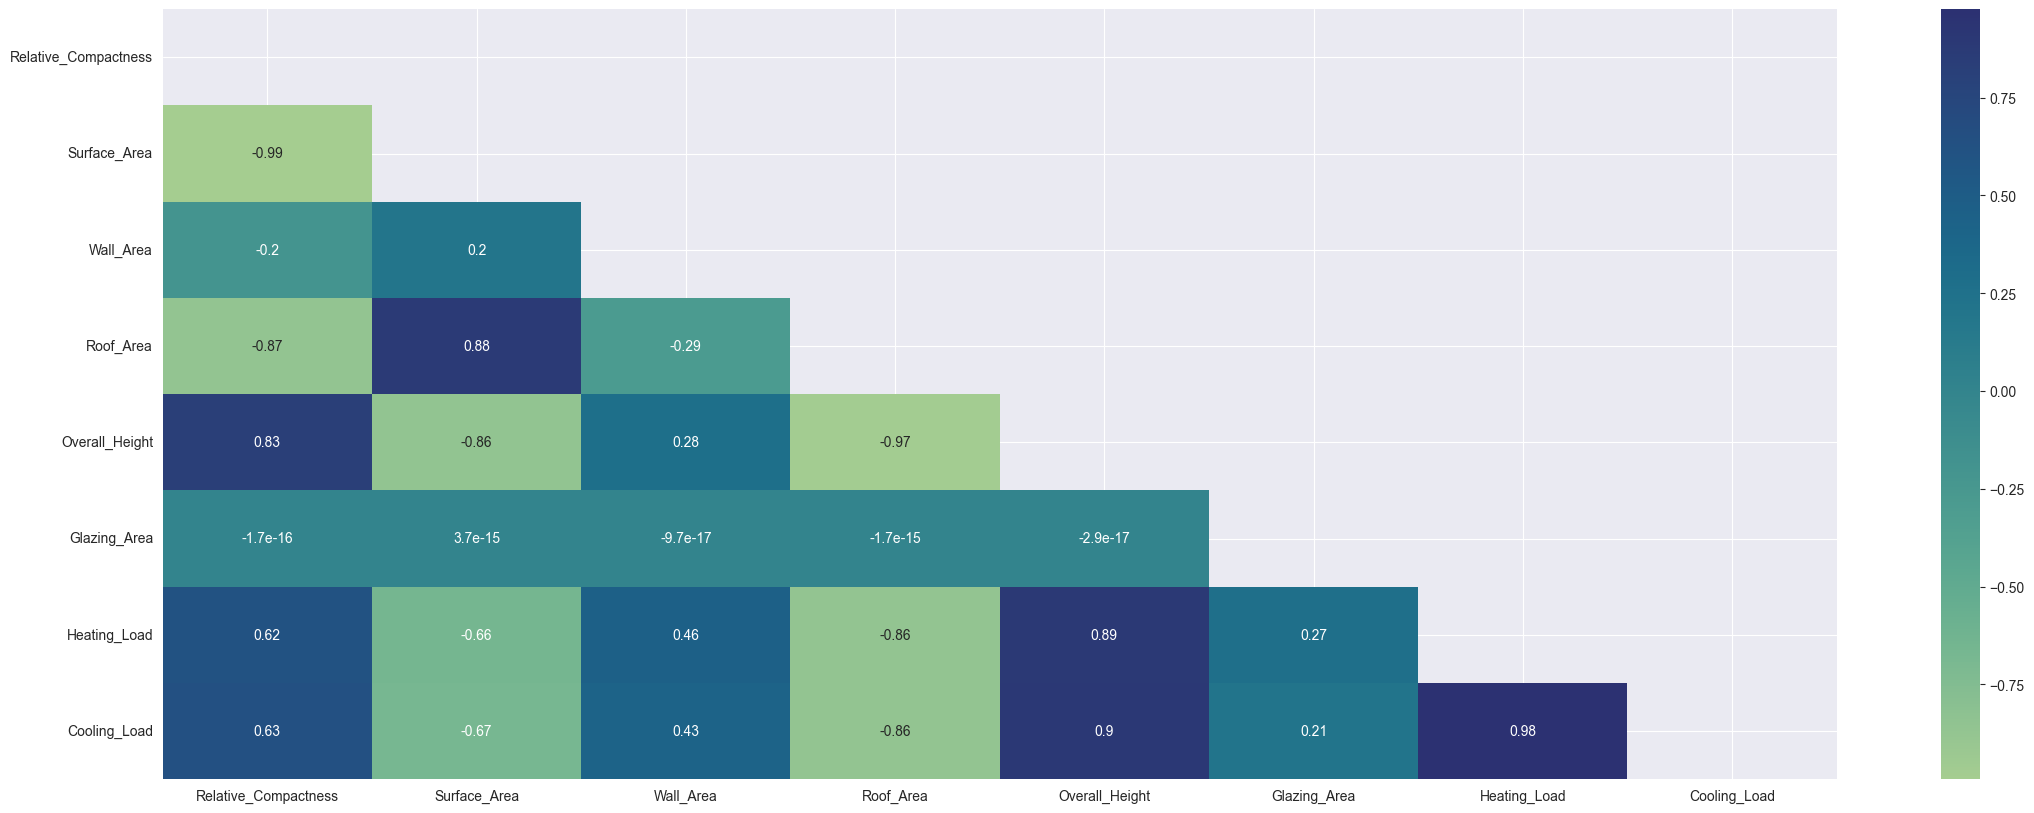

In [13]:
# Pearson's Correlation:
plot_correlation(df[num_cols])

In [14]:
# Chi-squared:
def ch2_func(features, target):
    cat_columns = features.columns
    statistics = []
    p_values = []
    
    for feature in cat_columns:
        # Creating a contingency table:
        df_contingency = pd.crosstab(features[feature], target)

        # Chi squared:
        statistic, p_value, dof, expected = chi2_contingency(df_contingency)
    
        statistics.append(statistic)
        p_values.append(p_value)
        
    dicionario = dict(Chi_Squared=statistics, P_value=p_values)
    df_ch = pd.DataFrame(index=cat_columns, data=dicionario)
    return df_ch

In [15]:
# Categorical Correlation with Heatig Load:
corr = ch2_func(df[cat_cols], df["Heating_Load"])
corr

,Chi_Squared,P_value
Orientation,1765.866667,0.422975
Glazing_Area_Distribution,3108.977778,0.009005


In [16]:
# Categorical Correlation with Cooling Load:
corr = ch2_func(df[cat_cols], df["Cooling_Load"])
corr

,Chi_Squared,P_value
Orientation,1928.000000,0.35126
Glazing_Area_Distribution,3277.333333,0.10045


Conclusions:
- There are some Multicollinearity between Overall Height and Roof Area, and Overall Height and Relative Compactess. 
- Cooling Load and Heating Load are extremelly correlated with each other.
- Surface Area have a negative correlation with Cooling and Heating Load.
- The Glazing Area is the least correlated nurical variable with the Respose variables.
- Overall Height is the most correlated variable with the Response variables.
- Regarding the categorical explanatory variables, Oriatation does not seem to be correlated with any one of the Response variables.
- Glazing Area Distribution is strongly correlated with Heating Load(Assuming p-value limit of 0.05), but not with Cooling Load.

### 2.3) Exploring relations between Variables

#### 2.3.1) Relative Compactness and Cooling/Heating loads 

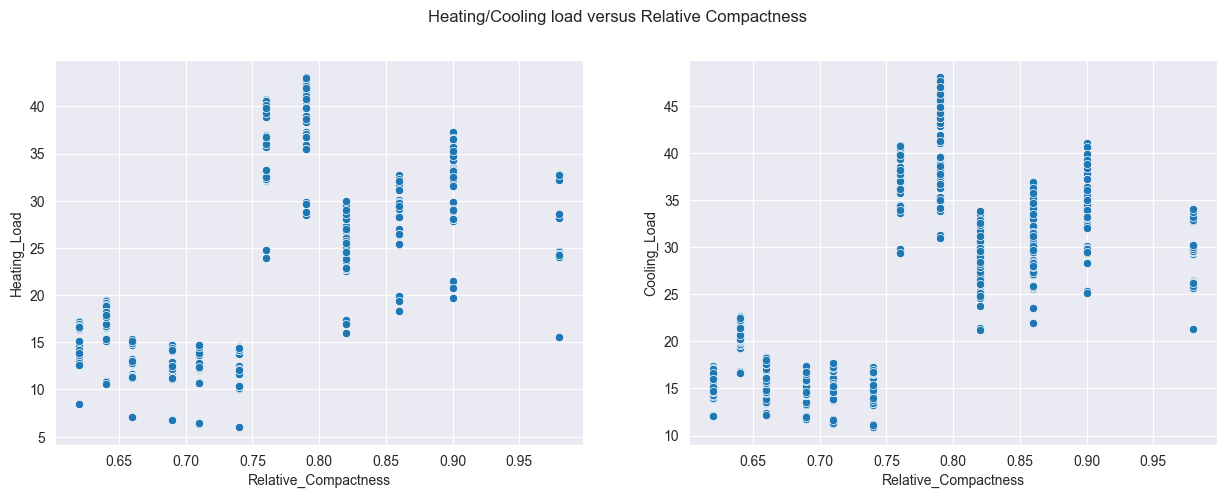

In [88]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Relative Compactness")
sns.scatterplot(x=df["Relative_Compactness"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Relative_Compactness"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.2) Surface Area and Cooling/Heating loads 

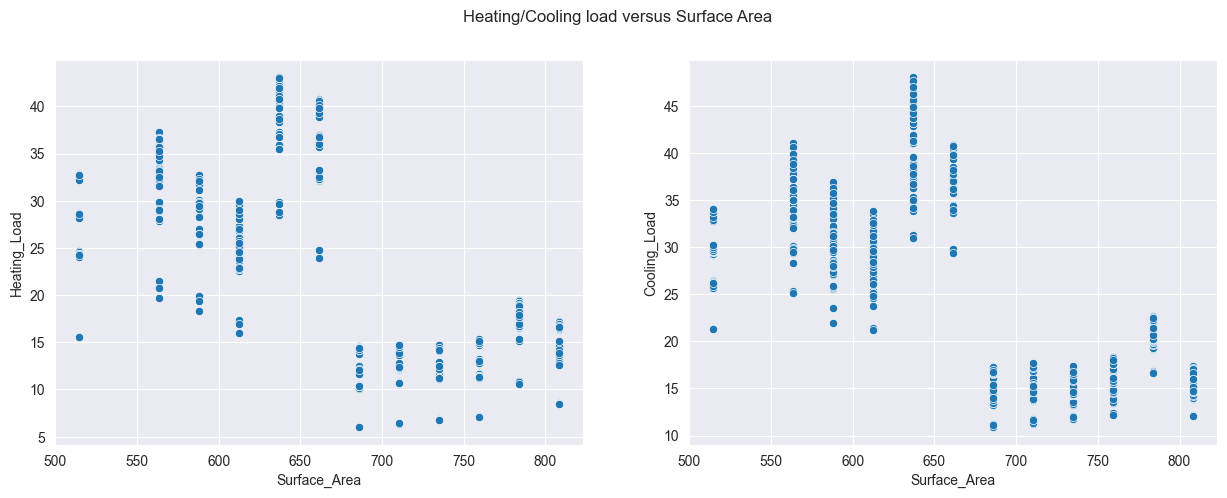

In [89]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Surface Area")
sns.scatterplot(x=df["Surface_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Surface_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.3) Wall Area and Cooling/Heating loads 

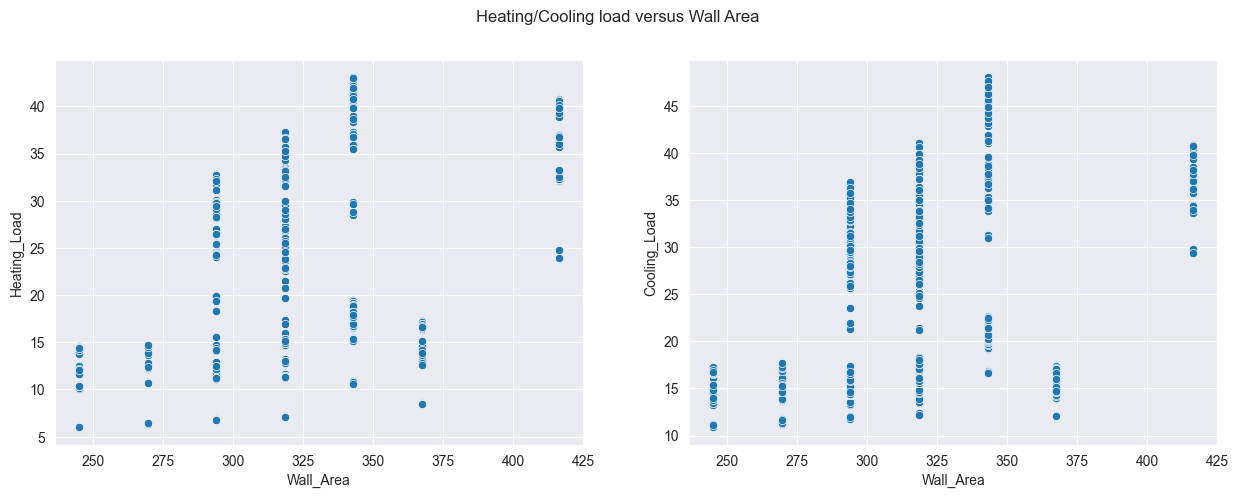

In [90]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Wall Area")
sns.scatterplot(x=df["Wall_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Wall_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.4) Roof Area and Cooling/Heating loads 

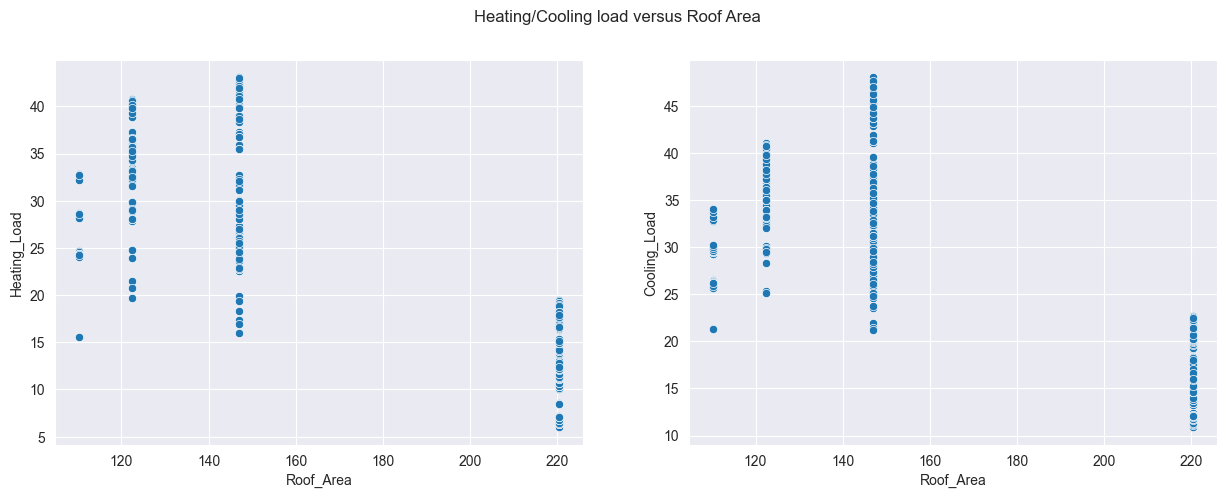

In [91]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Roof Area")
sns.scatterplot(x=df["Roof_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Roof_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.5) Overall Height and Cooling/Heating loads 

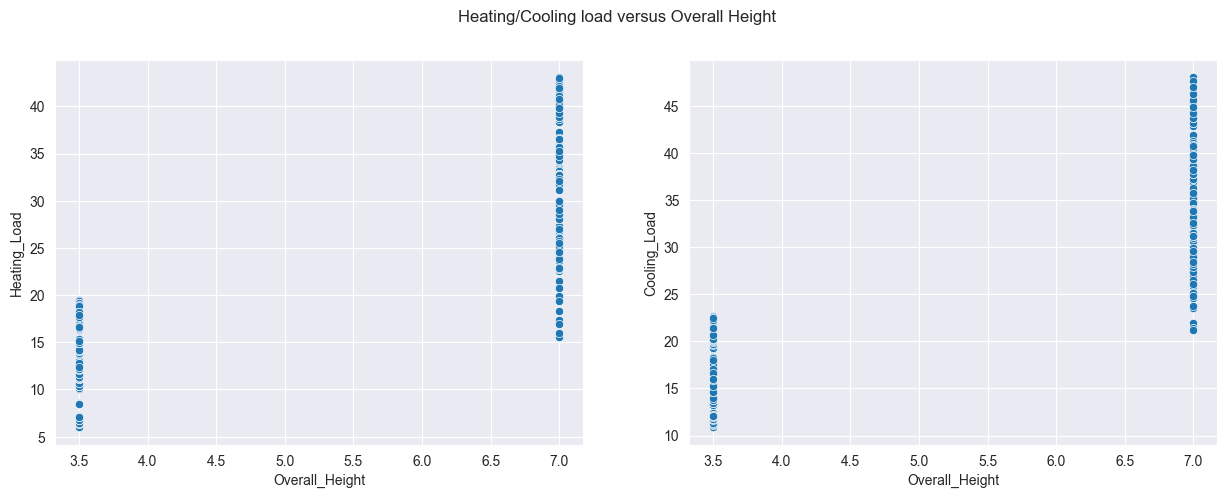

In [92]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Overall Height")
sns.scatterplot(x=df["Overall_Height"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Overall_Height"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.6) Orientation and Cooling/Heating loads

In [93]:
def map_orientation(row):
    if row == 2:
        return "North"
    elif row == 3:
        return "East"
    elif row == 4:
        return "South"
    else:
        return "West"

In [94]:
data_orientation_mapped = df["Orientation"].apply(map_orientation)
new_dataframe = df[["Heating_Load", "Cooling_Load"]].copy()
new_dataframe["Orientation_mapped"] = data_orientation_mapped
grouped = new_dataframe.groupby("Orientation_mapped", observed=False).mean().reset_index()

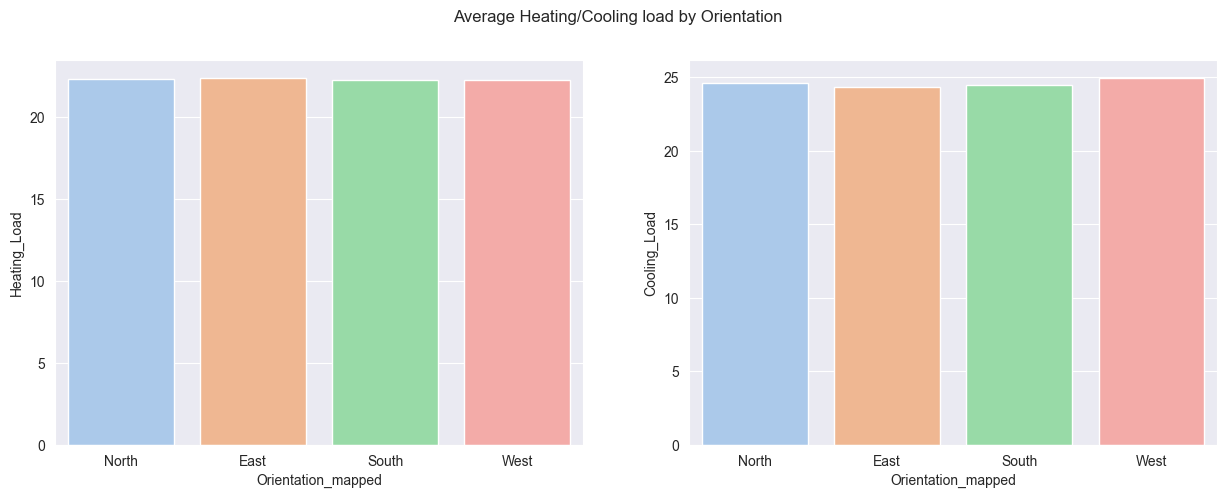

In [95]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Average Heating/Cooling load by Orientation")
sns.barplot(x=grouped["Orientation_mapped"], y=grouped["Heating_Load"], ax=ax[0], 
            hue=grouped["Orientation_mapped"], legend=False, palette="pastel")

sns.barplot(x=grouped["Orientation_mapped"], y=grouped["Cooling_Load"], ax=ax[1], 
            hue=grouped["Orientation_mapped"], legend=False, palette="pastel");

#### 2.3.7) Glazing Area and Cooling/Heating loads

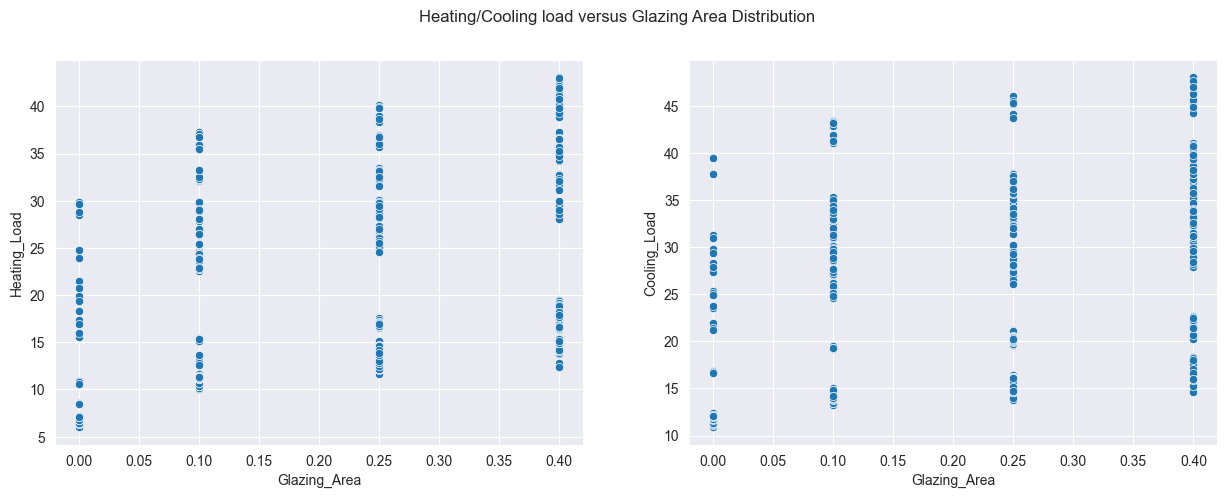

In [96]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Glazing Area Distribution")
sns.scatterplot(x=df["Glazing_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Glazing_Area"], y=df["Cooling_Load"], ax=ax[1]);

#### 2.3.8) Glazing Area Distribution and Cooling/Heating loads

In [97]:
df["Glazing_Area_Distribution"].value_counts()

Glazing_Area_Distribution
1    144
2    144
3    144
4    144
5    144
0     48
Name: count, dtype: int64

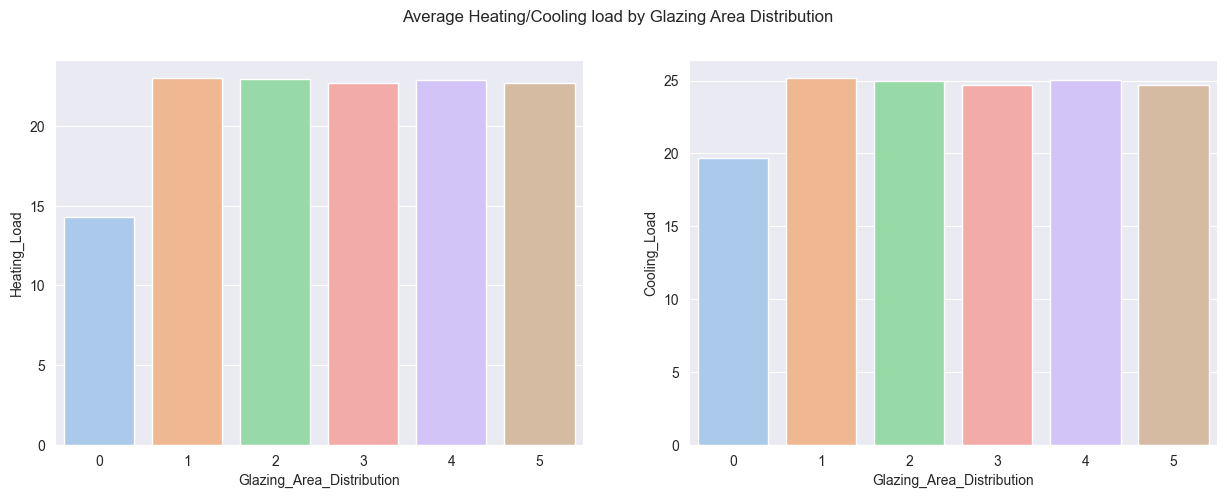

In [98]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Average Heating/Cooling load by Glazing Area Distribution")
df_grouped_glazing_area_dist = df.groupby("Glazing_Area_Distribution", observed=False)[["Heating_Load", "Cooling_Load"]].mean().reset_index()
sns.barplot(x=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], y=df_grouped_glazing_area_dist["Heating_Load"], ax=ax[0], 
            hue=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], legend=False, palette="pastel")

sns.barplot(x=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], y=df_grouped_glazing_area_dist["Cooling_Load"], ax=ax[1],
            hue=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], legend=False, palette="pastel");

## 3) Preprocessing

In [17]:
seed = 42
features = df.drop(columns=["Heating_Load", "Cooling_Load"])
targets = df[["Heating_Load", "Cooling_Load"]]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, shuffle=True, random_state=seed)

### 3.1) Categorical Transformation

In [55]:
one_hot = OneHotEncoder(sparse_output=False, drop="first", dtype=np.int8)
cat_train_transf = one_hot.fit_transform(X_train[cat_cols])
cat_test_transf = one_hot.transform(X_test[cat_cols])

In [56]:
X_train.drop(columns=cat_cols, inplace=True)
X_test.drop(columns=cat_cols, inplace=True)
X_train[one_hot.get_feature_names_out()] = cat_train_transf
X_test[one_hot.get_feature_names_out()] = cat_test_transf

In [58]:
X_train.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Glazing_Area,Orientation_3,Orientation_4,Orientation_5,Glazing_Area_Distribution_1,Glazing_Area_Distribution_2,Glazing_Area_Distribution_3,Glazing_Area_Distribution_4,Glazing_Area_Distribution_5
334,0.62,808.5,367.5,220.5,3.5,0.25,0,1,0,1,0,0,0,0
139,0.64,784.0,343.0,220.5,3.5,0.10,0,0,1,0,1,0,0,0
485,0.90,563.5,318.5,122.5,7.0,0.25,1,0,0,0,0,0,0,1
547,0.79,637.0,343.0,147.0,7.0,0.40,0,0,1,1,0,0,0,0
18,0.79,637.0,343.0,147.0,7.0,0.00,0,1,0,0,0,0,0,0


### 3.2) Feature Selection

In [104]:
# Class that put together many feature selection techniques:

class feature_selector:
    seed = 42
    def __init__(self, X, y) -> None:
        self.X_train = X
        self.y_train = y
    
    def  randomforestR_imp(self) -> None:
        model = RandomForestRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting RandomForest Regression Importance:
        plt.title("RandomForest Importance - " + self.y_train.name)
        plt.xlabel("Importance")
        fig = sns.barplot(x=series.values, y=series.index, hue=series.index, palette="pastel", legend=False)
        fig.set_ylabel('')
        

    def xgbR_imp(self) -> None:
        model = XGBRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting XGboost Regression Feature Importance:
        plt.title("XGBoost Feature Importance - " + self.y_train.name)
        plt.xlabel("Importance")
        fig = sns.barplot(y=series.index, x=series.values, hue=series.index, palette="pastel", legend=False)
        fig.set_ylabel('')

    # Univariate feature selection:
    def univariate(self, statistic, n="all") -> None:
        selector = SelectKBest(score_func=statistic, k=n)
        selector.fit(self.X_train, self.y_train)
        
        series = pd.Series(index=selector.feature_names_in_, data=selector.scores_).\
            sort_values(ascending=False)
        plt.title("F-Regression Filtering - " + self.y_train.name)
        plt.xlabel("F-score")
        fig = sns.barplot(y=series.index, x=series.values, hue=series.index, palette="pastel", legend=False)
        fig.set_ylabel('')

        return selector, fig
    
    # Wrapper method for feature selection:
    def refcv(self):
        
        models = {
            "Lasso":Lasso(random_state=feature_selector.seed),
            "Ridge":Ridge(random_state=feature_selector.seed),
            "RandomForestR":RandomForestRegressor(random_state=feature_selector.seed),
            "ExtraTreeR":ExtraTreesRegressor(random_state=feature_selector.seed),
            "XGB":XGBRegressor(random_state=feature_selector.seed)
        }

        splits=10
        cross = KFold(n_splits=splits, random_state=feature_selector.seed, shuffle=True)
        ind = [f"Columns {i}" for i in range(1, len(self.X_train.columns) + 1)]
        df = pd.DataFrame(index=ind)
        
        minimo = np.inf
        name = ""
        for key, model in models.items():
            rfecv = RFECV(estimator=model, step=1, cv=cross, min_features_to_select=1, scoring="neg_mean_squared_error")
            rfecv.fit(self.X_train, self.y_train)
            root_mean = np.sqrt(-rfecv.cv_results_["mean_test_score"])
            df[key] = root_mean
            best_value = root_mean[np.argmin(root_mean)]

            if minimo > best_value:
                minimo = best_value
                best_features = rfecv.support_
                name = key

        df_features = pd.DataFrame(columns=self.X_train.columns, data=best_features.reshape(1, -1), index=[name])
    
        return df,  df_features.transpose()
    

#### 3.2.1) Filtering Selection

Filtering selection is a statistical feature selection technique that is based on the correlation score or dependence between the input variable and the target variable. So, after calculate this correlation or dependence based on a statistical approach, the variables can be filtered to choose the most relevant features. Since this problem have categorical and numerical data, the method below it is not appropriate, since the f-regression assume numerical features and numerical target. However, it will be used anyway, to see what is going to generate. 

In [105]:
f_selector_heat = feature_selector(X_train, y_train["Heating_Load"])
f_selector_cool = feature_selector(X_train, y_train["Cooling_Load"])

Heating Load:

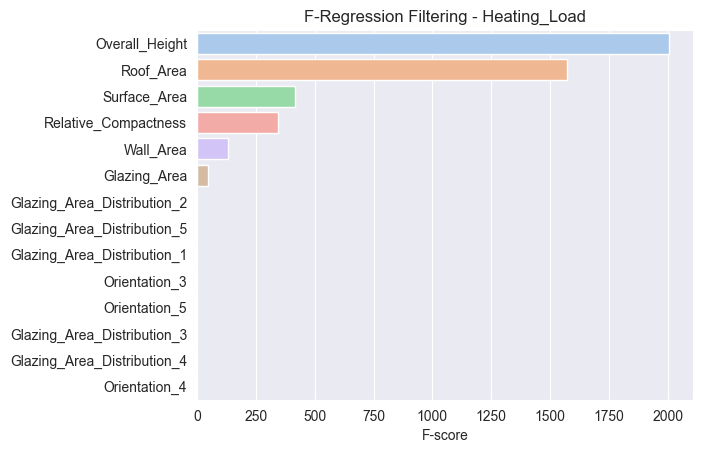

In [106]:
_, ax_heat = f_selector_heat.univariate(statistic=f_regression)

Cooling load:

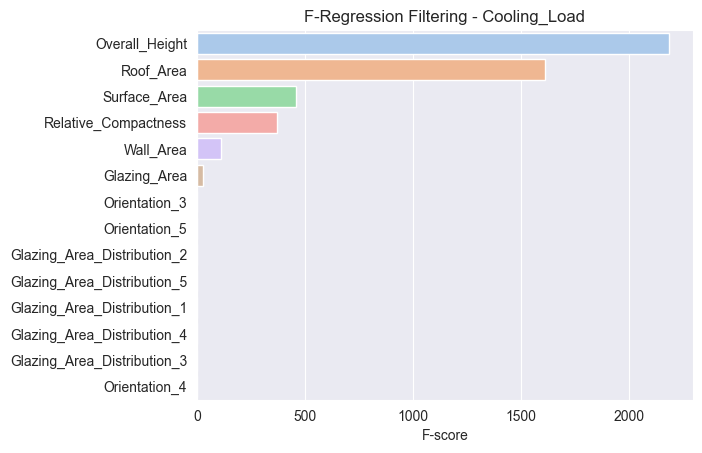

In [107]:
_, ax_cool = f_selector_cool.univariate(statistic=f_regression)

Conclusions:
- The F-regression approach shows that the only important features for modeling Cooling and Heating Load are, Overall Height, Roof Area, Surface Area, Surface Compactness, Wall Area and Glazing Area. (The numerical ones)

#### 3.2.2) Random Forest Importance

Heating Load:

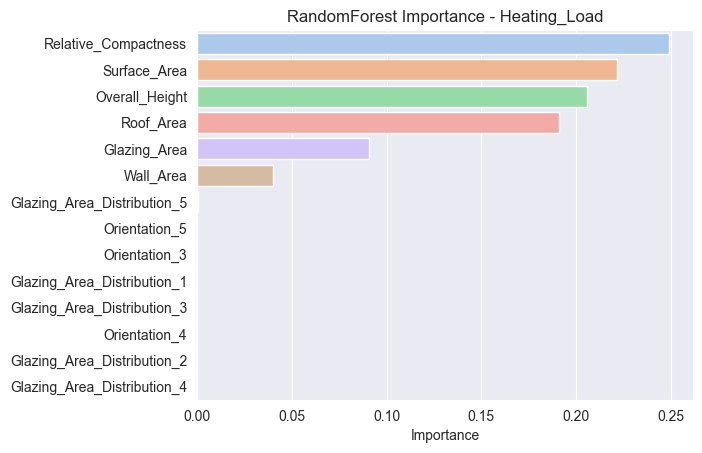

In [108]:
f_selector_heat.randomforestR_imp()

Cooling Load

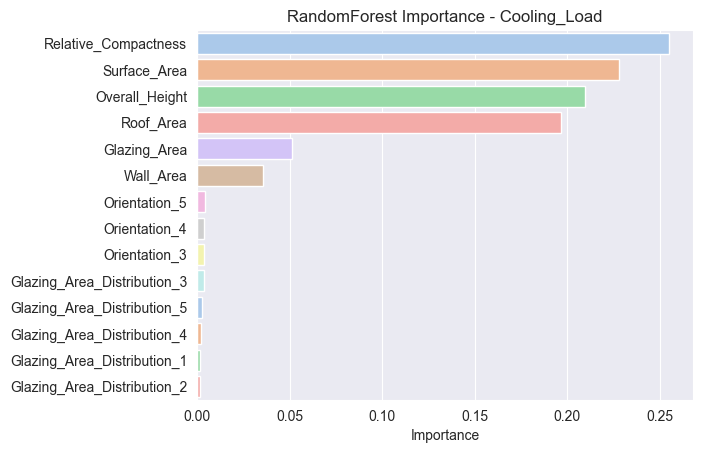

In [109]:
f_selector_cool.randomforestR_imp()

Conclusions:
- The Random Forest importance shows that Relative Compactness is the most important feature and for modelling Cooling and Heating Load.
- The categorical Features are less important based on this approach.
- The importance order of the first siz features are the for both Target variables.

#### 3.2.3) XGBoost Importance

Heating Load

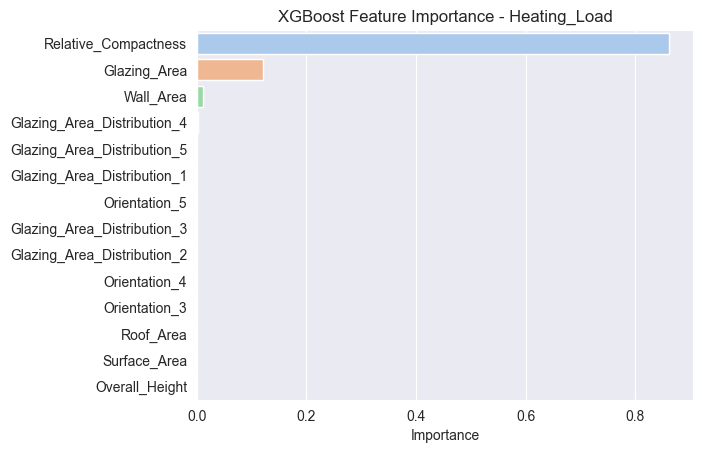

In [110]:
f_selector_heat.xgbR_imp()

Cooling Load

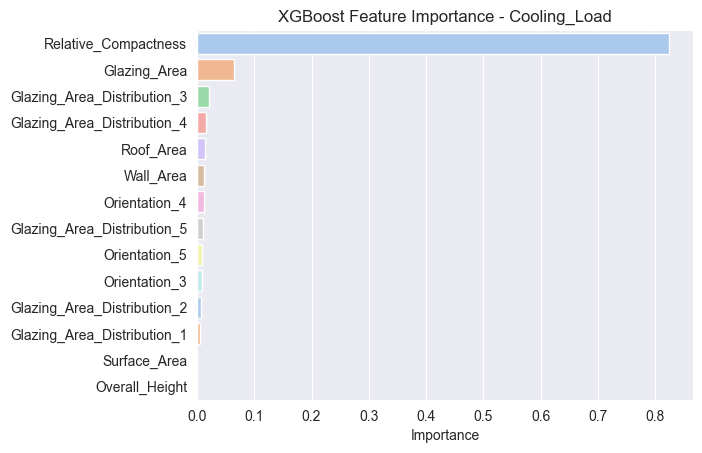

In [111]:
f_selector_cool.xgbR_imp()

Conclusions:
- The Xgboost importance selects, basically, three of the fourteen features.
- Relative Compactness is the most important feature for modelling Cooling and Heating Load.

#### 3.2.4) Recursive Feature Elimination (RFE)

Recursive Feature Elimination (REF) is a feature selection technique that first fits an arbitrary estimator with all the features, and then uses an importance or coefficient attribute to identify the least important variable. It then drops this variable and fits another model without it until it reaches the minimal number of features.

Heating Load:

In [112]:
df_results, df_features = f_selector_heat.refcv()

In [113]:
display(df_results)
display(df_features)

,Lasso,Ridge,RandomForestR,ExtraTreeR,XGB
Columns 1,9.049256,7.944896,3.168256,4.649530,3.166720
Columns 2,4.654702,7.447839,3.168256,4.408233,0.487845
Columns 3,4.654702,3.229058,3.168256,3.166719,0.487805
Columns 4,4.654702,3.255531,3.168256,0.487696,0.488669
Columns 5,4.654702,3.276499,0.511380,0.487695,0.492795
Columns 6,4.654702,3.264698,0.511874,0.487701,0.496219
Columns 7,4.654702,3.205819,0.526240,0.491274,0.507068
Columns 8,4.654702,3.113832,0.525180,0.510244,0.495124
Columns 9,4.654702,3.092927,0.537841,0.514879,0.491984
Columns 10,4.654702,3.093520,0.542342,0.536256,0.467112


,XGB
Relative_Compactness,True
Surface_Area,False
Wall_Area,True
Roof_Area,True
Overall_Height,False
Glazing_Area,True
Orientation_3,True
Orientation_4,True
Orientation_5,True
Glazing_Area_Distribution_1,True


Cooling Load

In [114]:
df_results, df_features = f_selector_cool.refcv()

In [115]:
display(df_results)
display(df_features)

,Lasso,Ridge,RandomForestR,ExtraTreeR,XGB
Columns 1,8.344955,7.369181,2.702331,4.234779,2.697678
Columns 2,4.473626,7.103461,2.702331,4.008131,1.718501
Columns 3,4.464892,3.374807,2.702331,2.697678,1.802838
Columns 4,4.464894,3.401609,2.702331,2.697678,1.869002
Columns 5,4.464894,3.404670,1.720901,1.718463,1.963378
Columns 6,4.464894,3.397339,1.721829,1.718457,1.912751
Columns 7,4.464894,3.408552,1.796088,1.853419,1.824659
Columns 8,4.464894,3.383908,1.802905,2.047016,1.685694
Columns 9,4.464894,3.369163,1.885025,2.072569,1.444472
Columns 10,4.464894,3.363168,1.912022,2.203391,1.329572


,XGB
Relative_Compactness,True
Surface_Area,False
Wall_Area,True
Roof_Area,True
Overall_Height,False
Glazing_Area,True
Orientation_3,True
Orientation_4,True
Orientation_5,True
Glazing_Area_Distribution_1,False


Concusions:

- 

### 3.3) Numerical Transformation

#### 3.3.1) MinMax Scaler

In [59]:
min_max = MinMaxScaler()
X_train_min_max = X_train.copy()
X_test_min_max = X_test.copy()
num_cols_features = [i for i in num_cols if i not in ["Heating_Load", "Cooling_Load"]]

X_train_min_max[num_cols_features] = min_max.fit_transform(X_train[num_cols_features])
X_test_min_max[num_cols_features] = min_max.transform(X_test[num_cols_features])

#### 3.3.2) Standard Scaler

In [60]:
std_scaler = StandardScaler()
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[num_cols_features] = std_scaler.fit_transform(X_train[num_cols_features])
X_test_std[num_cols_features] = std_scaler.transform(X_test[num_cols_features])

### 3.4) Selection the best Algorithm and Transformation

In [25]:
# Function used to evaluate the best algorithms:

def melhor_modelo(X_train, y_train):

    seed = 42
    cv = 5
    score = ['neg_root_mean_squared_error', 'r2']
    result_rmse = {}
    result_r2 = {}

    dicionario = { 
                "Lasso":Lasso(random_state=seed),
                "Ridge":Ridge(random_state=seed),
                "SVR":SVR(),
                "RandomForestR":RandomForestRegressor(random_state=seed),
                "ExtraTreeR":ExtraTreesRegressor(random_state=seed),
                "XGB":XGBRegressor(random_state=seed),
                "MLP":MLPRegressor(random_state=seed, max_iter=2000)
                 }


    for name, model in dicionario.items():
        k_fold = KFold(n_splits=cv, random_state=seed, shuffle=True)
        result = cross_validate(model, X_train, y_train, cv=k_fold, scoring=score)

        result_rmse[name] = -result['test_neg_root_mean_squared_error']
        result_r2[name] = result['test_r2']
        
        
    result_pd_rmse = pd.DataFrame(data=result_rmse)
    result_pd_r2 = pd.DataFrame(data=result_r2)
    
    return result_pd_rmse, result_pd_r2
    

#### 3.4.1) Using Min Max Scaler

Heating Load:

In [119]:
result_rmse, result_r2 = melhor_modelo(X_train_min_max, y_train["Heating_Load"])

In [120]:
result_rmse.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,5.042065,2.890405,3.400302,0.562126,0.583993,0.444724,2.577591
std,0.432794,0.194898,0.291618,0.066227,0.059539,0.039268,0.214733
min,4.372925,2.593264,3.066203,0.503545,0.502884,0.394055,2.304832
25%,4.905461,2.791374,3.131826,0.518447,0.559817,0.414195,2.447193
50%,5.197523,3.002687,3.455577,0.535546,0.578889,0.457448,2.587250
75%,5.213533,3.010702,3.631294,0.586558,0.618003,0.469953,2.686229
max,5.520881,3.054000,3.716609,0.666535,0.660371,0.487969,2.862450


In [121]:
result_r2.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.748795,0.916031,0.885367,0.996744,0.996517,0.998005,0.932548
std,0.022832,0.018000,0.014099,0.001267,0.001137,0.000496,0.019612
min,0.713024,0.888714,0.869946,0.994546,0.994646,0.997288,0.899404
25%,0.746843,0.912679,0.876546,0.996796,0.996378,0.997782,0.932443
50%,0.747085,0.915111,0.884574,0.997300,0.996863,0.998041,0.937655
75%,0.765227,0.927429,0.888784,0.997451,0.997081,0.998373,0.943615
max,0.771794,0.936223,0.906983,0.997626,0.997619,0.998538,0.949621


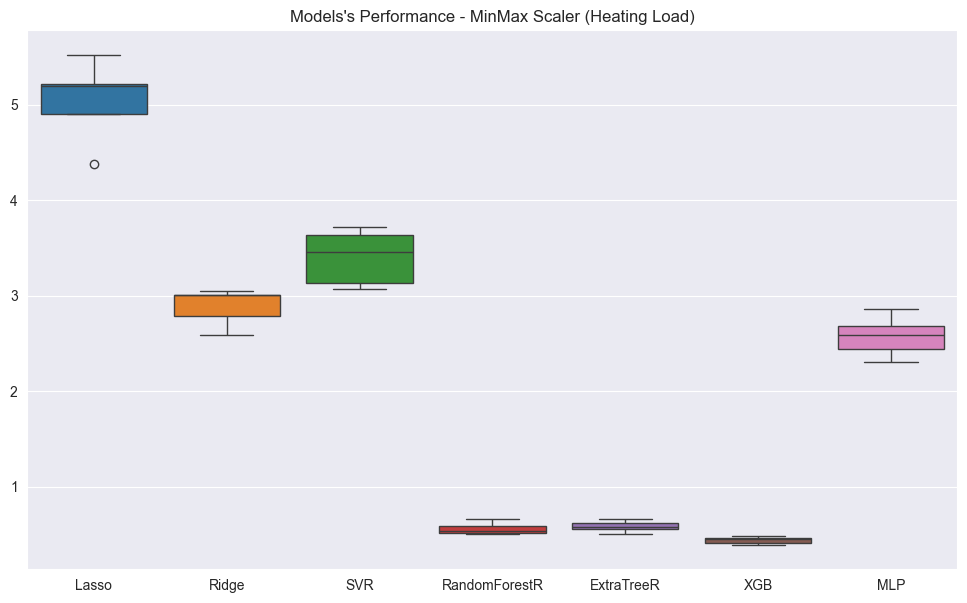

In [122]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - MinMax Scaler (Heating Load)")
sns.boxplot(result_rmse);

Cooling Load:

In [123]:
result_rmse, result_r2 = melhor_modelo(X_train_min_max, y_train["Cooling_Load"])

In [124]:
result_rmse.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,4.658941,3.291001,3.542562,1.868460,2.222156,1.390522,3.015761
std,0.512041,0.169768,0.443925,0.118310,0.303038,0.204865,0.191562
min,3.748515,3.054686,2.765074,1.728070,1.803809,1.050734,2.823126
25%,4.807299,3.212556,3.645525,1.813288,2.142235,1.383684,2.837586
50%,4.873248,3.332232,3.698338,1.841338,2.214278,1.420521,3.052119
75%,4.901905,3.343569,3.717165,1.917731,2.305270,1.522859,3.081307
max,4.963737,3.511959,3.886709,2.041873,2.645189,1.574812,3.284667


In [125]:
result_r2.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.758910,0.878996,0.860632,0.960992,0.944928,0.978496,0.896276
std,0.025629,0.008841,0.018746,0.003527,0.010497,0.003956,0.027306
min,0.740874,0.869263,0.843713,0.956866,0.927611,0.974342,0.848836
25%,0.741949,0.872398,0.854683,0.958160,0.944110,0.975610,0.900146
50%,0.751407,0.878524,0.855593,0.961322,0.946724,0.978799,0.903625
75%,0.757192,0.883337,0.856294,0.963159,0.951784,0.979196,0.912508
max,0.803128,0.891459,0.892878,0.965454,0.954412,0.984531,0.916262


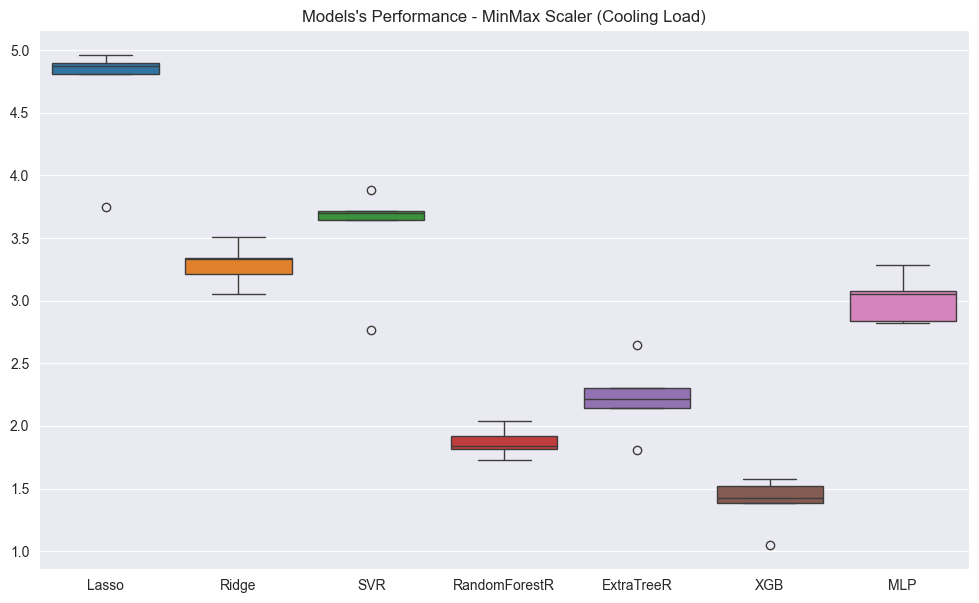

In [126]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - MinMax Scaler (Cooling Load)")
sns.boxplot(result_rmse);

#### 3.4.2) Using Standard Scaler

Heating Load:

In [138]:
result_rmse_std, result_r2_std = melhor_modelo(X_train_std, y_train["Heating_Load"])

In [139]:
result_rmse_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.421220,2.847934,2.757281,0.562335,0.583993,0.444724,0.923128
std,0.295563,0.201290,0.232355,0.066064,0.059539,0.039268,0.192733
min,3.030271,2.567457,2.414927,0.504372,0.502884,0.394055,0.785392
25%,3.240000,2.704537,2.638104,0.518519,0.559817,0.414195,0.796590
50%,3.447082,2.961861,2.819704,0.535450,0.578889,0.457448,0.798117
75%,3.611148,2.972664,2.934406,0.586800,0.618003,0.469953,1.012407
max,3.777601,3.033149,2.979264,0.666532,0.660371,0.487969,1.223131


In [140]:
result_r2_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.883384,0.918216,0.923078,0.996742,0.996517,0.998005,0.990846
std,0.018727,0.019567,0.020398,0.001266,0.001137,0.000496,0.005411
min,0.865643,0.887049,0.891026,0.994546,0.994646,0.997288,0.981633
25%,0.871118,0.916800,0.918928,0.996793,0.996378,0.997782,0.990280
50%,0.877912,0.917868,0.925563,0.997301,0.996863,0.998041,0.994036
75%,0.889330,0.931874,0.935180,0.997450,0.997081,0.998373,0.994090
max,0.912918,0.937486,0.944694,0.997618,0.997619,0.998538,0.994192


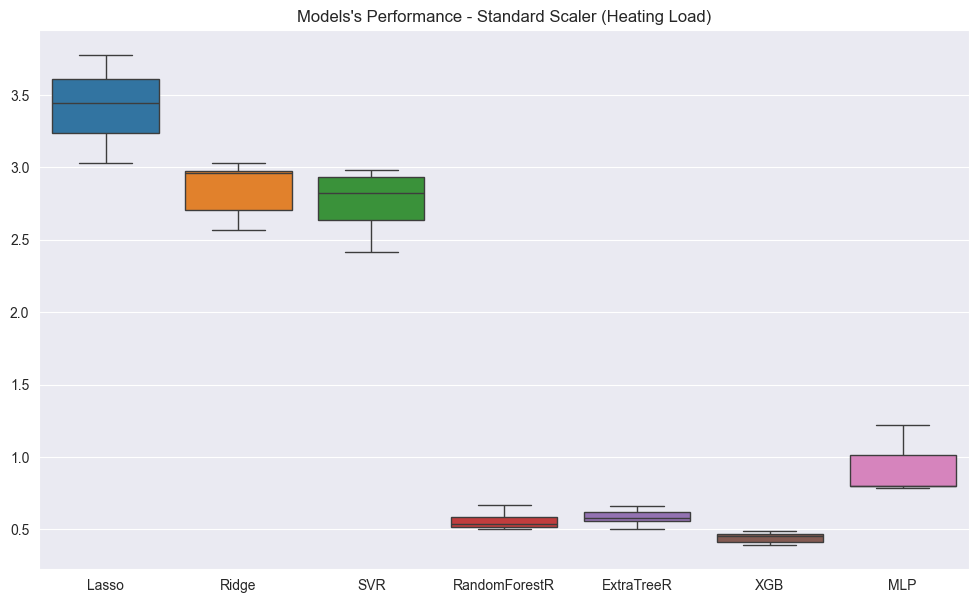

In [141]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - Standard Scaler (Heating Load)")
sns.boxplot(result_rmse_std);

Cooling Load:

In [142]:
result_rmse_std, result_r2_std = melhor_modelo(X_train_std, y_train["Cooling_Load"])

In [143]:
result_rmse_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.685760,3.247382,3.110703,1.865212,2.222156,1.390522,1.991382
std,0.336779,0.138961,0.205337,0.115331,0.303038,0.204865,0.156105
min,3.104098,3.101484,2.792694,1.729417,1.803809,1.050734,1.835263
25%,3.692441,3.106673,3.079860,1.812624,2.142235,1.383684,1.884282
50%,3.833145,3.298862,3.159051,1.845578,2.214278,1.420521,1.967169
75%,3.866677,3.310807,3.163276,1.898583,2.305270,1.522859,2.035760
max,3.932440,3.419087,3.358636,2.039855,2.645189,1.574812,2.234437


In [144]:
result_r2_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.848974,0.881873,0.892139,0.961121,0.944928,0.978496,0.955289
std,0.011299,0.011939,0.006197,0.003534,0.010497,0.003956,0.008331
min,0.840013,0.865227,0.883296,0.956951,0.927611,0.974342,0.945781
25%,0.840346,0.879057,0.890727,0.958095,0.944110,0.975610,0.947544
50%,0.842758,0.881751,0.891562,0.962090,0.946724,0.978799,0.957124
75%,0.856752,0.884833,0.894868,0.962989,0.951784,0.979196,0.961420
max,0.864999,0.898496,0.900240,0.965480,0.954412,0.984531,0.964577


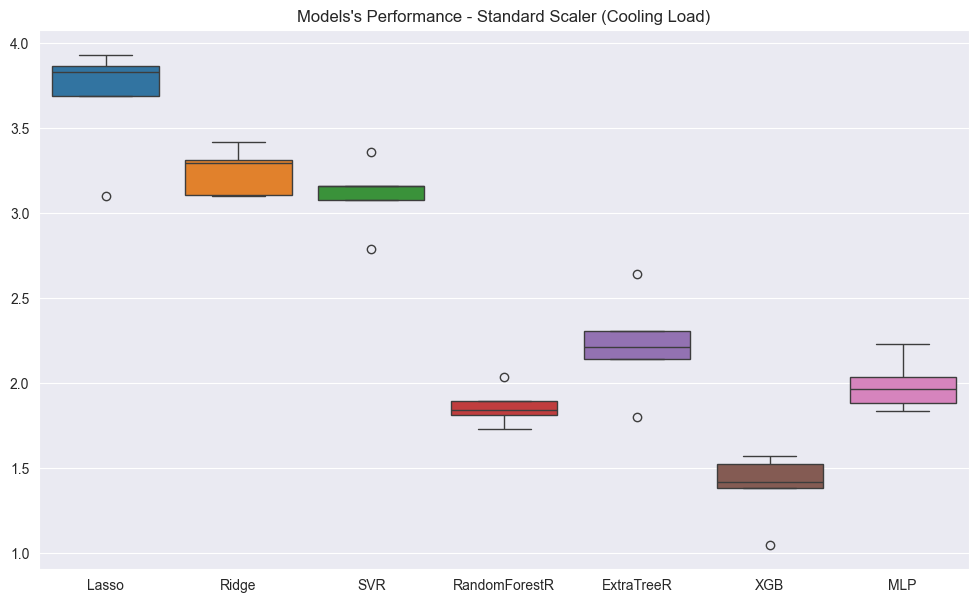

In [145]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - Standard Scaler (Cooling Load)")
sns.boxplot(result_rmse_std);

## 4) Fine Tuning

In [26]:
# Function for fine tuning an arbitrary model:

def tuning(X_train, y_train, modelo, params):
    
    cv = 5
    score = "neg_root_mean_squared_error"
    grid  = GridSearchCV(modelo, cv=cv, param_grid=params, 
                         scoring=score, 
                         n_jobs=-1,
                         return_train_score=True,
                         )

    grid.fit(X_train, y_train)

    best_index = grid.best_index_
    result = grid.cv_results_

    train_score = -result['mean_train_score'][best_index]
    left_out = -result['mean_test_score'][best_index]



    print(f"Train score: {train_score}")
    print(f"Left out data score: {left_out}")

    return grid.best_estimator_

In [45]:
def save_model(model, file_name):
    try:
        joblib.dump(model, f"models/{file_name}.joblib")
    except:
        os.makedirs("models")
        path = f"models/{file_name}.joblib"
        joblib.dump(model, path)

In [36]:
grid = {"n_estimators":[100, 150, 200],
        "max_depth":[4, 5, 6],
        "learning_rate":[0.01, 0.001, 0.05],
        "subsample":[0.4, 0.5, 1],
        "lambda":[2, 3]
        }

Heating Load

In [37]:
model_xgb_heating = XGBRegressor()
best_estimator_heating = tuning(X_train_min_max, y_train["Heating_Load"], model_xgb_heating, grid)

Train score: 0.33242785930633545
Left out data score: 0.46134116053581237


Cooling Load

In [38]:
model_xgb_cooling = XGBRegressor()
best_estimator_cooling = tuning(X_train_min_max, y_train["Cooling_Load"], model_xgb_cooling, grid)

Train score: 0.5641761898994446
Left out data score: 1.3416208505630494


In [47]:
# Saving the best model:

save_model(best_estimator_heating, "xgboost_model_heating")
save_model(best_estimator_cooling, "xgboost_model_cooling")

## 5) Modelling and Results

In [49]:
# Training the best model using the whole training set:

best_model_heating = clone(best_estimator_heating)
best_model_cooling = clone(best_estimator_cooling)

best_model_heating.fit(X_train_min_max, y_train["Heating_Load"])
best_model_cooling.fit(X_train_min_max, y_train["Cooling_Load"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...)

### Predictions

Heating Load

In [66]:
y_pred = best_model_heating.predict(X_train_min_max)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train["Heating_Load"]))
r2_train = r2_score(y_pred, y_train["Heating_Load"])

print("Train set:")
print(f"RMSE: {rmse_train}")
print(f"R2: {r2_train}\n")

y_pred = best_model_heating.predict(X_test_min_max)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test["Heating_Load"]))
r2_test = r2_score(y_pred, y_test["Heating_Load"])

print("Test set:")
print(f"RMSE: {rmse_test}")
print(f"R2: {r2_test}")

Train set:
RMSE: 0.3467511832714081
R2: 0.9988114274108927

Test set:
RMSE: 0.4431281089782715
R2: 0.9980475455920298


Cooling Load

In [68]:
y_pred = best_model_cooling.predict(X_train_min_max)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train["Cooling_Load"]))
r2_train = r2_score(y_pred, y_train["Cooling_Load"])

print("Train set:")
print(f"RMSE: {rmse_train}")
print(f"R2: {r2_train}\n")


y_pred = best_model_cooling.predict(X_test_min_max)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test["Cooling_Load"]))
r2_test = r2_score(y_pred, y_test["Cooling_Load"])

print("Test set:")
print(f"RMSE: {rmse_test}")
print(f"R2: {r2_test}")

Train set:
RMSE: 0.5499542355537415
R2: 0.9966062278440135

Test set:
RMSE: 1.239819884300232
R2: 0.9829503199151737
